In [1]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

In [2]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
import matplotlib.pyplot as plt
import re
import string
from sentence_transformers import SentenceTransformer

In [3]:
seed = 20522001

## Data Treatment

#### Data Exploration

In [4]:
df = pd.read_csv('tweet_dataset.csv')
df.head()

,date,id,username,text,retweets,likes
0,2010-08-31 16:13:03,22629609170,TTuberville,Hope to see the Raider nation at Raider Walk t...,6,0
1,2010-09-02 15:12:21,22806173687,TTuberville,Be there tonight at Ruby Tequila's from 6 to 7...,4,0
2,2010-09-03 14:59:11,22894114050,TTuberville,Thanks for coming out to the show last night.....,0,0
3,2010-09-04 16:58:53,22990051461,TTuberville,Raider Power tv show starts today and througho...,6,0
4,2010-09-04 20:55:56,23004266274,TTuberville,Wear Red and see all of you fans at RAIDER WAL...,4,1


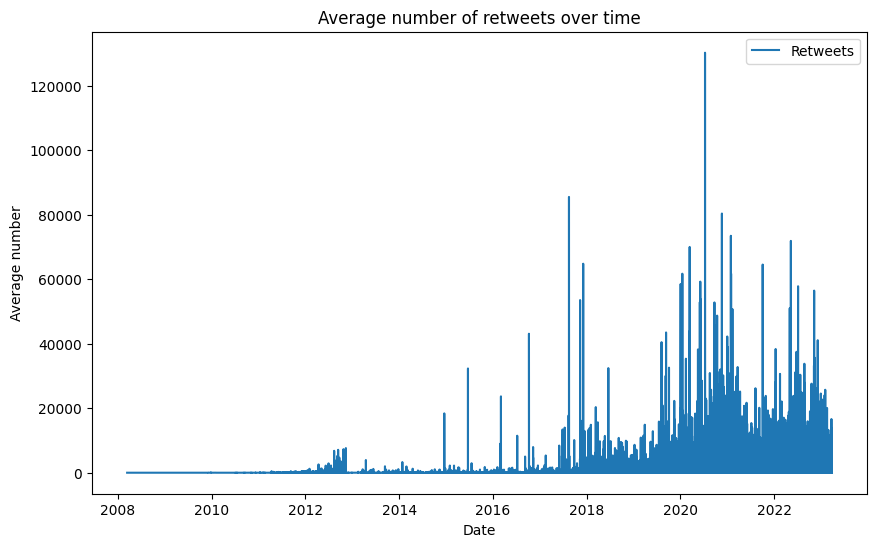

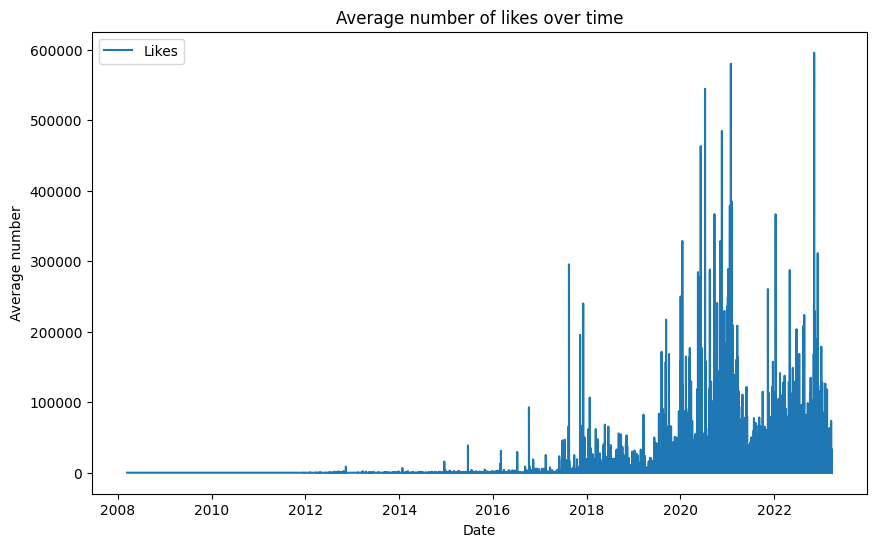

In [5]:
# Convert the date column to a datetime object
df['date'] = pd.to_datetime(df['date'])

# Group the dataframe by date and calculate the mean of retweets and likes for each date
grouped_df = df.groupby('date').mean()

# Plot the average number of retweets over time
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(grouped_df.index, grouped_df['retweets'], label='Retweets')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average number')
ax1.set_title('Average number of retweets over time')
ax1.legend()
plt.show()

# Plot the average number of likes over time
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(grouped_df.index, grouped_df['likes'], label='Likes')
ax2.set_xlabel('Date')
ax2.set_ylabel('Average number')
ax2.set_title('Average number of likes over time')
ax2.legend()
plt.show()

#### Preprocessing

In [6]:
misspell_dict = {"aren't": "are not", "can't": "cannot", "couldn't": "could not",
                 "didn't": "did not", "doesn't": "does not", "don't": "do not",
                 "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                 "he'd": "he would", "he'll": "he will", "he's": "he is",
                 "i'd": "I had", "i'll": "I will", "i'm": "I am", "isn't": "is not",
                 "it's": "it is", "it'll": "it will", "i've": "I have", "let's": "let us",
                 "mightn't": "might not", "mustn't": "must not", "shan't": "shall not",
                 "she'd": "she would", "she'll": "she will", "she's": "she is",
                 "shouldn't": "should not", "that's": "that is", "there's": "there is",
                 "they'd": "they would", "they'll": "they will", "they're": "they are",
                 "they've": "they have", "we'd": "we would", "we're": "we are",
                 "weren't": "were not", "we've": "we have", "what'll": "what will",
                 "what're": "what are", "what's": "what is", "what've": "what have",
                 "where's": "where is", "who'd": "who would", "who'll": "who will",
                 "who're": "who are", "who's": "who is", "who've": "who have",
                 "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                 "you'll": "you will", "you're": "you are", "you've": "you have",
                 "'re": " are", "wasn't": "was not", "we'll": " will", "tryin'": "trying"}


def _get_misspell(misspell_dict):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    return misspell_dict, misspell_re


def replace_typical_misspell(text):
    misspellings, misspellings_re = _get_misspell(misspell_dict)

    def replace(match):
        return misspellings[match.group(0)]

    return misspellings_re.sub(replace, text)
    

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


def clean_text(x):
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    return re.sub(r'\d+', ' ', x)

# lower
df['text'] = df['text'].str.lower()
# clean misspellings
df['text'] = df['text'].apply(replace_typical_misspell)
# clean the text
df['text'] = df['text'].apply(clean_text)
# clean numbers
df['text'] = df['text'].apply(clean_numbers)
# strip
df['text'] = df['text'].str.strip()
# Drop empty tweets
df['text'].replace('', np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,date,id,username,text,retweets,likes
0,2010-08-31 16:13:03,22629609170,TTuberville,hope to see the raider nation at raider walk t...,6,0
1,2010-09-02 15:12:21,22806173687,TTuberville,be there tonight at ruby tequila ' s from ...,4,0
2,2010-09-03 14:59:11,22894114050,TTuberville,thanks for coming out to the show last night ...,0,0
3,2010-09-04 16:58:53,22990051461,TTuberville,raider power tv show starts today and througho...,6,0
4,2010-09-04 20:55:56,23004266274,TTuberville,wear red and see all of you fans at raider wal...,4,1


## Topic modelling

We split the dataset to perform topic modeling on a subsample, and then build our labels for a supervised classifier

In [20]:
docs = df.sample(5000, random_state=seed)['text'].to_numpy()

topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2023-04-02 23:13:19,767 - BERTopic - Transformed documents to Embeddings
2023-04-02 23:13:33,421 - BERTopic - Reduced dimensionality
2023-04-02 23:13:33,889 - BERTopic - Clustered reduced embeddings


In [38]:
topics = topic_model.get_topic_info()
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1816,-1_to_the_co_and
1,0,170,0_covid_vaccine_coronavirus_pandemic
2,1,159,1_court_judge_supreme_fbi
3,2,114,2_county_at_great_co
4,3,94,3_thank_you_thanks_giselefetterman
...,...,...,...
86,85,11,85_hate_white_bigotry_discrimination
87,86,11,86_feingold_wisen_pledge_ron
88,87,11,87_housing_rent_affordable_heat
89,88,11,88_tech_employees_sec_legal


In [22]:
topic_model.visualize_topics()

In [45]:

topics_list=["International Politics",
             "National Issues"
             "Social Issues",
             "Security",
             "Economics",
             "Public Health",
             "Justice",
             "Others"
             ]
new_topics = ["Others","Public Health","Justice","National Issues","Others",
              "International Politics","Social Issues","Social Issues","Others",
              "International Politics","Social Issues","Economics","Social Issues",
              "Public Health","Security","Social Issues","International Politics",
              "Others","National Issues","Social Issues","Social Issues","Social Issues",
              "Public Health","Economics","Education","National Issues","Social Issues",
              "Others","Education","Social Issues","International Politics","Security",
              "Social Issues", "National Issues","National Issues","International Politics",
              "National Issues","Public Health","Security","Others","National Issues",
              "Others","Economics","Social Issues","Others","Economics","Social Issues",
              "National Issues","Social Issues","National Issues","International Politics",
              "National Issues","Others","National Issues","National Issues","National Issues",
              "Security","Economics", "Economics","Economics","Social Issues",
              "Security","Public Health","National Issues","Others","Security",
              "Social Issues","National Issues","Others","Others","International Politics",
              "National Issues", "Social Issues","Social Issues","National Issues",
              "Others","Social Issues","Others","Economics","Others","National Issues",
              "Others","Others","Social Issues","National Issues","National Issues",
              "Social Issues","Others","Social Issues","Social Issues","National Issues"]

new_topics_classification = topics
new_topics_classification["Topic"] = new_topics
# new_topics_classification
new_topics_classification.groupby(["Topic"]).sum()



,Count
Topic,
Economics,235
Education,66
International Politics,328
Justice,159
National Issues,573
Others,2314
Public Health,321
Security,184
Social Issues,820


In [51]:
new_topics_dict = {i-1:new_topics[i] for i in range(len(new_topics))}
new_topic_model = topic_model
new_topic_model.set_topic_labels(new_topics_dict)
new_topic_model.get_topic_info()
new_topic_model.custom_labels_

['Others',
 'Public Health',
 'Justice',
 'National Issues',
 'Others',
 'International Politics',
 'Social Issues',
 'Social Issues',
 'Others',
 'International Politics',
 'Social Issues',
 'Economics',
 'Social Issues',
 'Public Health',
 'Security',
 'Social Issues',
 'International Politics',
 'Others',
 'National Issues',
 'Social Issues',
 'Social Issues',
 'Social Issues',
 'Public Health',
 'Economics',
 'Education',
 'National Issues',
 'Social Issues',
 'Others',
 'Education',
 'Social Issues',
 'International Politics',
 'Security',
 'Social Issues',
 'National Issues',
 'National Issues',
 'International Politics',
 'National Issues',
 'Public Health',
 'Security',
 'Others',
 'National Issues',
 'Others',
 'Economics',
 'Social Issues',
 'Others',
 'Economics',
 'Social Issues',
 'National Issues',
 'Social Issues',
 'National Issues',
 'International Politics',
 'National Issues',
 'Others',
 'National Issues',
 'National Issues',
 'National Issues',
 'Security',
 'Econo

In [10]:
topic_model.reduce_topics(docs, nr_topics=20)

2023-04-02 22:22:32,845 - BERTopic - Reduced number of topics from 86 to 20


In [11]:
topic_model.visualize_topics()